In [2]:
import numpy as np
import os
from keras.models import Sequential, Model
from keras.layers import Dense, Input, merge
from keras.layers import Reshape,LeakyReLU,ZeroPadding2D
from keras.layers.core import Activation, Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Convolution2D, MaxPooling2D, Deconvolution2D
from keras.layers.core import Flatten
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D
from keras.optimizers import SGD, Adagrad
from PIL import Image
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.objectives import binary_crossentropy
import tensorflow as tf
#from tqdm import tqdm
import scipy.misc as im
K.set_image_dim_ordering('tf') 
IN_CH = 3

In [1]:
import numpy as np
import glob, pickle
import os, sys
import argparse
#import cv2
from keras.models import Sequential, Model
from keras.layers import Dense, Input, merge
from keras.layers import Reshape
from keras.layers.core import Activation, Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Convolution2D, MaxPooling2D, Deconvolution2D
from keras.layers.core import Flatten
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D
from keras.optimizers import SGD, Adagrad
from PIL import Image
from keras import backend as K
from keras.layers.normalization import BatchNormalization
import math
K.set_image_dim_ordering('tf') 

img_rows = 256
img_cols = 256
SHAPE = 256
BATCH = 4
IN_CH = 3
OUT_CH = 3
LAMBDA = 100
NF = 64 # number of filter
BATCH_SIZE = 10


Using TensorFlow backend.


In [3]:
def split_input(img,mode='AtoB'):
    """
    img: an 512x256x3 image
    :return: [input, output]
    """
    input, output = img[:,:img_cols,:], img[:,img_cols:,:]

    if mode == 'BtoA':
        input, output = output, input
    return [input, output]

def get_data(datadir):
    #datadir = args.data
    # assume each image is 512x256 split to left and right
    imgs = glob.glob(os.path.join(datadir, '*.jpg'))
    data_X = np.zeros((len(imgs),img_rows,img_cols,3))
    data_Y = np.zeros((len(imgs),img_rows,img_cols,3))
    i = 0
    for file in imgs:
        #img = cv2.imread(file,cv2.IMREAD_COLOR)
        img=Image.open(file)
        img = img.resize((img_cols*2, img_rows), Image.LANCZOS)
        
        img = np.array(img)
        #img = cv2.resize(img, (img_cols*2, img_rows)) 
        #print('{} {},{}'.format(i,np.shape(img)[0],np.shape(img)[1]))
        

        X, Y = split_input(img)

        data_X[i,:,:,:] = X
        data_Y[i,:,:,:] = Y
        i = i+1
    return data_X, data_Y

In [4]:
data_x,data_y=get_data('test')


In [5]:
#cv2.imshow(data_x[0])
#cv2.waitKey(0)
print(type(data_x))
print(data_x.shape)
#img=data_x[0,:,:,:]
#cv2.imshow(img,'img')
#cv2.waitKey(0)

<class 'numpy.ndarray'>
(20, 256, 256, 3)


In [6]:
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Activation, Dropout, Flatten, Dense
from keras.layers.merge import Concatenate
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.utils import plot_model

In [7]:
def generator_model():
    
    input_tensor = Input(shape=(img_rows,img_cols,IN_CH)) # type: Input
    output_ch = 3
    filters=128
    x =                       Conv2D(         filters*1, kernel_size=(4, 4), strides=(2, 2), padding="same")( input_tensor )       ; e1 = x
    x = BatchNormalization()( Conv2D(         filters*2, kernel_size=(4, 4), strides=(2, 2), padding="same")( LeakyReLU(0.2)(x) ) ); e2 = x
    x = BatchNormalization()( Conv2D(         filters*4, kernel_size=(4, 4), strides=(2, 2), padding="same")( LeakyReLU(0.2)(x) ) ); e3 = x
    x = BatchNormalization()( Conv2D(         filters*8, kernel_size=(4, 4), strides=(2, 2), padding="same")( LeakyReLU(0.2)(x) ) ); e4 = x
    x = BatchNormalization()( Conv2D(         filters*8, kernel_size=(4, 4), strides=(2, 2), padding="same")( LeakyReLU(0.2)(x) ) ); e5 = x
    x = BatchNormalization()( Conv2D(         filters*8, kernel_size=(4, 4), strides=(2, 2), padding="same")( LeakyReLU(0.2)(x) ) ); e6 = x
    x = BatchNormalization()( Conv2D(         filters*8, kernel_size=(4, 4), strides=(2, 2), padding="same")( LeakyReLU(0.2)(x) ) ); e7 = x
    x =                       Conv2D(         filters*8, kernel_size=(4, 4), strides=(2, 2), padding="same")( LeakyReLU(0.2)(x) )  ; e8 = x
    # dec
    x = BatchNormalization()( Conv2DTranspose(filters*8, kernel_size=(4, 4), strides=(2, 2), padding="same")( Activation("relu")(x) ) ); x = Concatenate()([Dropout(0.5)(x), e7])
    x = BatchNormalization()( Conv2DTranspose(filters*8, kernel_size=(4, 4), strides=(2, 2), padding="same")( Activation("relu")(x) ) ); x = Concatenate()([Dropout(0.5)(x), e6])
    x = BatchNormalization()( Conv2DTranspose(filters*8, kernel_size=(4, 4), strides=(2, 2), padding="same")( Activation("relu")(x) ) ); x = Concatenate()([Dropout(0.5)(x), e5])
    x = BatchNormalization()( Conv2DTranspose(filters*8, kernel_size=(4, 4), strides=(2, 2), padding="same")( Activation("relu")(x) ) ); x = Concatenate()([x, e4])
    x = BatchNormalization()( Conv2DTranspose(filters*4, kernel_size=(4, 4), strides=(2, 2), padding="same")( Activation("relu")(x) ) ); x = Concatenate()([x, e3])
    x = BatchNormalization()( Conv2DTranspose(filters*2, kernel_size=(4, 4), strides=(2, 2), padding="same")( Activation("relu")(x) ) ); x = Concatenate()([x, e2])
    x = BatchNormalization()( Conv2DTranspose(filters*1, kernel_size=(4, 4), strides=(2, 2), padding="same")( Activation("relu")(x) ) ); x = Concatenate()([x, e1])
    x =                       Conv2DTranspose(output_ch, kernel_size=(4, 4), strides=(2, 2), padding="same")( Activation("relu")(x) )
    
    x = Activation("tanh")(x)
    
    unet = Model(inputs=input_tensor, outputs=x)
    
    return unet

In [8]:
gx=generator_model()
gx.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 128)     6272      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 256)       524544    
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 256)       1024      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 64, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 512)       2097664   
__________

In [9]:
from keras.models import load_model
model = load_model('g3.h5')
#gx.load_weights('g3.h5')

In [10]:
''' 
paths = 'images'+str('results')
if os.path.isdir(paths)==False:
    os.mkdir(paths)
for k in range(data_x.shape[0]):
    filename='pic'+str(k+1)+'.png'
    gg=os.path.join(paths, filename)
    gen_pic(data_y[k:k+1],gg)
''' 

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import display, Image

from glob import glob

In [11]:
import PIL
images = [ PIL.Image.open(f) for f in glob('test/*') ]

def img2array(im):
    if im.mode != 'RGB':
        im = im.convert(mode='RGB')
    return np.fromstring(im.tobytes(), dtype='uint8').reshape((im.size[1], im.size[0], 3))

np_images = [ img2array(im) for im in images ]

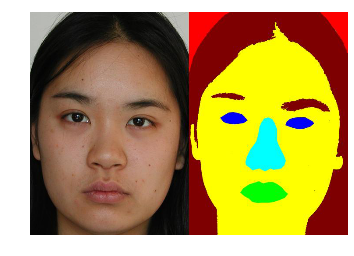

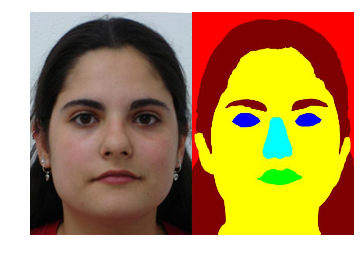

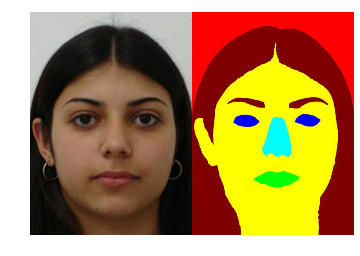

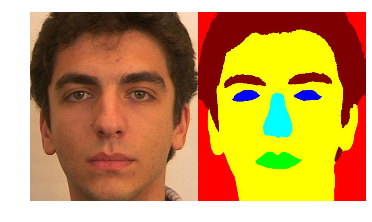

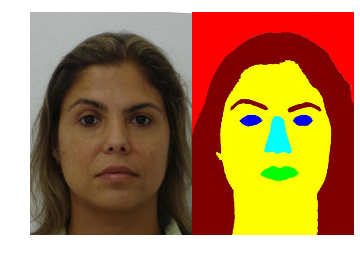

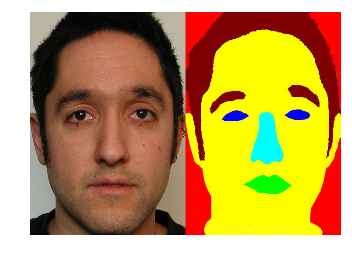

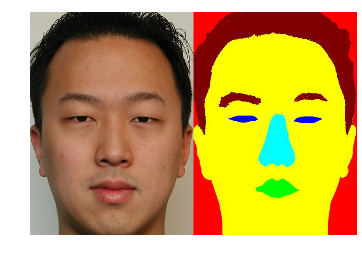

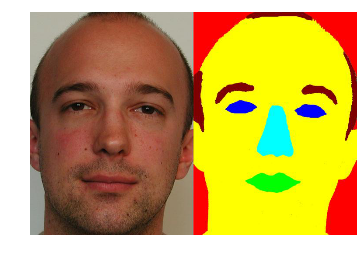

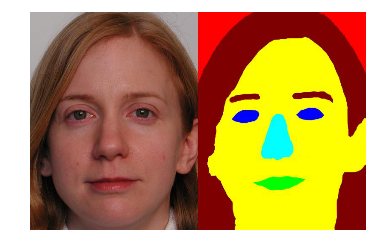

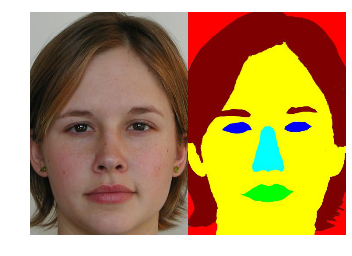

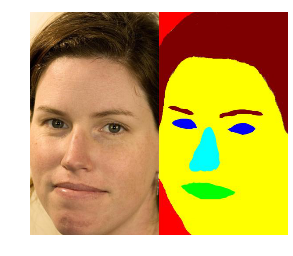

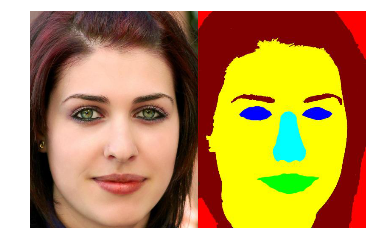

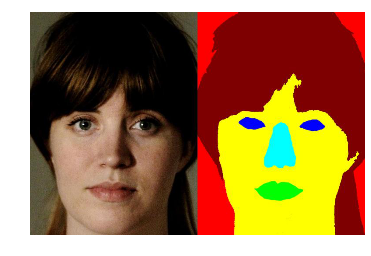

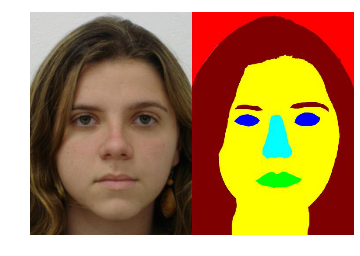

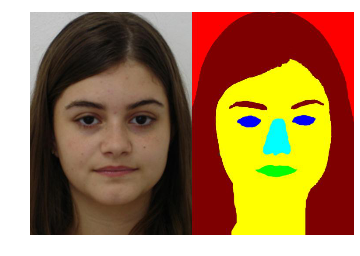

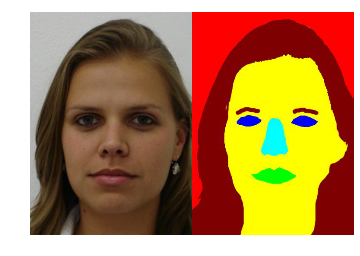

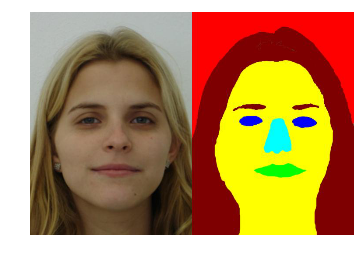

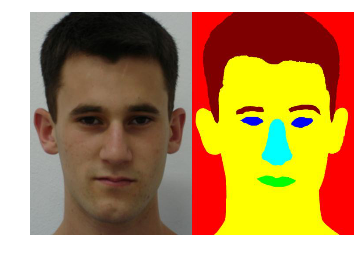

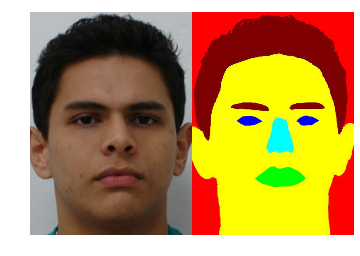

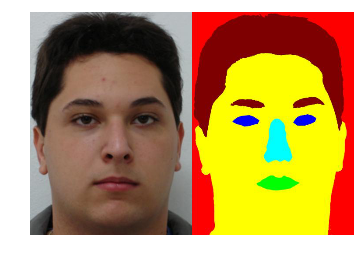

In [12]:
for img in np_images:
    plt.figure()
    plt.axis('off')
    plt.imshow(img)

In [14]:
''' 
for im in images:
    display(Image(filename=im.filename, retina=True))
''' 

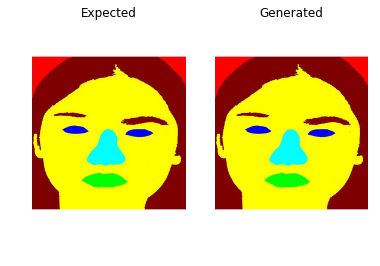

In [16]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

image = mpimg.imread('pic1.png')
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=False)
ax[0].imshow(image)
ax[0].autoscale(False)
ax[0].set_axis_off()
ax[0].set_title('Expected')

ax[1].imshow(image)
ax[1].autoscale(False)
ax[1].set_axis_off()
ax[1].set_title('Generated')


In [20]:
def generate(n,generator,data_x):
    
    target=data_x[n-1:n]
    pic = generator.predict(target)
    pic = np.squeeze(pic,axis=0)
    
    to_read='pic'+str(n)+'.png'
    image = mpimg.imread(to_read)
    image2=pic
    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=False)
    ax[0].imshow(image)
    ax[0].autoscale(False)
    ax[0].set_axis_off()
    ax[0].set_title('Expected')

    ax[1].imshow(image2)
    ax[1].autoscale(False)
    ax[1].set_axis_off()
    ax[1].set_title('Generated')

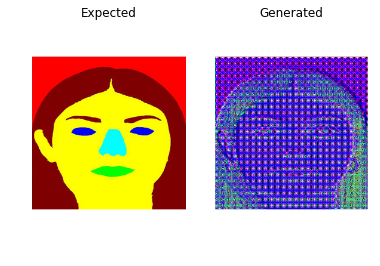

In [21]:
generate(3,gx,data_x)